In this Notebook we will use the GradientBoostingRegressor or the RF regressor to predict the salaries. After that we will predict some fake data to compare the salaries for 3 different people. At last we will plot the feature importance.

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Mean Absolute Error: 10682.483609068628
Best Parameters: {'regressor__subsample': 0.6, 'regressor__n_estimators': 500, 'regressor__max_depth': 3, 'regressor__learning_rate': 0.1, 'regressor__gamma': 0.1, 'regressor__colsample_bytree': 1.0}
   Age Gender Education Level          Job Title  Years of Experience  \
0   27   Male             PhD  Software Engineer                    4   
1   27   Male      Bachelor's  Software Engineer                    4   
2   27   Male        Master's  Software Engineer                    1   
3   27   Male      Bachelor's     Data Scientist                    1   

   Predicted Salary  
0     101514.265625  
1     118895.210938  
2      53779.519531  
3     115385.179688  


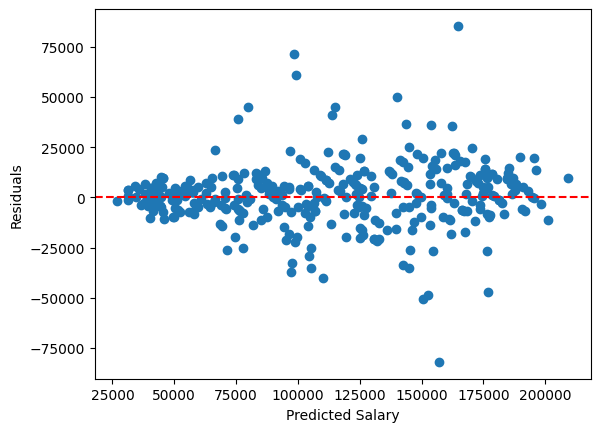

In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

# Load the CSV data
path = 'Salary_Data.csv'

df = pd.read_csv(path)
df['Education Level'] = df['Education Level'].replace("Bachelor's Degree", "Bachelor's")
df['Education Level'] = df['Education Level'].replace("phD", "PhD")
df['Education Level'] = df['Education Level'].replace("Master's Degree", "Master's")

df = df.dropna()
df.drop_duplicates(inplace=True)
df = df[df["Salary"] > 10000]



# Features and target
X = df.drop('Salary', axis=1)
y = df['Salary']



# Define categorical and numerical columns
categorical_columns = ['Gender', 'Education Level', 'Job Title']
numerical_columns = ['Age', 'Years of Experience']

# Preprocess categorical variables with OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
         ('num', StandardScaler(), numerical_columns)
    ]
)

# Build a pipeline with RandomForestRegressor
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    #('regressor',RandomForestRegressor(random_state=42))
    ('regressor',XGBRegressor(random_state=42, learning_rate=0.01))
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

""" param_grid = {
    "regressor__n_estimators": [100, 200, 300],
    "regressor__max_depth": [5, 10, 20, 30, None],
    "regressor__min_samples_split": [10, 20, 30, 40, ],
    "regressor__min_samples_leaf": [1, 2, 4],
    "regressor__max_features": [None, "sqrt", "log2"],
} """

param_grid = {
    "regressor__n_estimators": [100, 200, 500, 1000],  # Number of trees
    "regressor__learning_rate": [0.01, 0.05, 0.1, 0.2],  # Step size shrinkage
    "regressor__max_depth": [3, 5, 7, 10],  # Maximum depth of trees
    "regressor__subsample": [0.6, 0.8, 1.0],  # Fraction of samples for training
    "regressor__colsample_bytree": [0.6, 0.8, 1.0],  # Fraction of features used per tree
    "regressor__gamma": [0, 0.1, 0.2, 0.4],  # Minimum loss reduction for split
}

# Perform Randomized Search for Hyperparameter Tuning
search = RandomizedSearchCV(
    model,
    param_distributions=param_grid,
    n_iter=100,
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)
search.fit(X_train, y_train)

# Get the best model and evaluate it
best_model = search.best_estimator_
predictions = best_model.predict(X_test)

# Train the model
#model.fit(X_train, y_train)

# Evaluate the model
#predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f'Mean Absolute Error: {mae}')
print("Best Parameters:", search.best_params_)

# Example fake data for prediction
fake_data = pd.DataFrame({
    'Age': [27, 27, 27, 27],
    'Gender': ['Male', 'Male', 'Male', "Male"],
    'Education Level': ["PhD", "Bachelor's", "Master's", "Bachelor's"],
    'Job Title': ['Software Engineer', 'Software Engineer', 'Software Engineer', "Data Scientist"],
    'Years of Experience': [4, 4, 1, 1]
})


# Predict salaries for fake data
predicted_salaries = best_model.predict(fake_data)
fake_data['Predicted Salary'] = predicted_salaries

print(fake_data)
plt.scatter(predictions, y_test - predictions)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Salary')
plt.ylabel('Residuals')
plt.show()


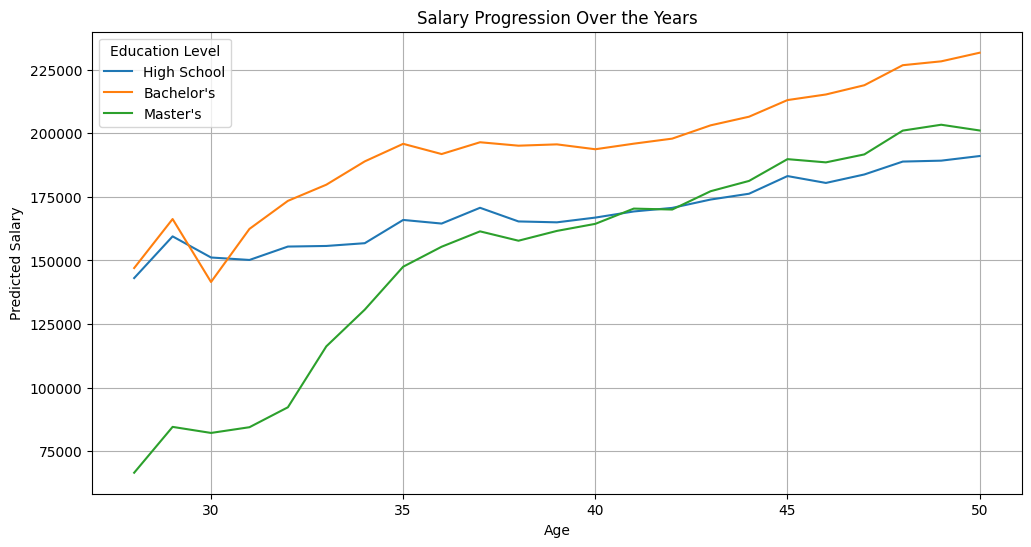

    Age Gender Education Level          Job Title  Years of Experience  \
23   28   Male      Bachelor's  Software Engineer                    5   
24   29   Male      Bachelor's  Software Engineer                    6   
25   30   Male      Bachelor's  Software Engineer                    7   
26   31   Male      Bachelor's  Software Engineer                    8   
27   32   Male      Bachelor's  Software Engineer                    9   

    Predicted Salary  
23     147024.906250  
24     166280.171875  
25     141543.531250  
26     162406.953125  
27     173422.734375  


In [36]:
#Create a comparison of the three people
import pandas as pd
import matplotlib.pyplot as plt

# Example fake data generation
start_age = 28
end_age = 50

# Define the template data for the three people
people = [
    {"Gender": "Male", "Education Level": "High School", "Job Title": "Software Engineer", "start_work": 7},
    {"Gender": "Male", "Education Level": "Bachelor's", "Job Title": "Software Engineer", "start_work": 5},
    {"Gender": "Male", "Education Level": "Master's", "Job Title": "Software Engineer", "start_work": 3}
]

# Generate the data for each person over the years
fake_data_list = []
for person in people:
    for age in range(start_age, end_age + 1):
        # Calculate Years of Experience as the difference between the current age and the start age (27)
        years_of_experience = age - start_age
        fake_data_list.append({
            "Age": age,
            "Gender": person["Gender"],
            "Education Level": person["Education Level"],
            "Job Title": person["Job Title"],
            "Years of Experience": years_of_experience + person["start_work"]
        })

# Create a DataFrame from the generated data
fake_data = pd.DataFrame(fake_data_list)


# Predict salaries for the generated fake data
predicted_salaries = best_model.predict(fake_data)
fake_data['Predicted Salary'] = predicted_salaries

# Plot the results
plt.figure(figsize=(12, 6))

# Plot salary progression for each education level
for education_level in fake_data["Education Level"].unique():
    subset = fake_data[fake_data["Education Level"] == education_level]
    plt.plot(subset["Age"], subset["Predicted Salary"], label=f"{education_level}")

# Add plot details
plt.title("Salary Progression Over the Years")
plt.xlabel("Age")
plt.ylabel("Predicted Salary")
plt.legend(title="Education Level")
plt.grid(True)
plt.show()

# Print the fake data with predictions (optional)
print(fake_data[fake_data["Education Level"] == "Bachelor's"].head())



Filtered Feature Importances (Excluding Job Title):
                              Feature  Importance
183          num__Years of Experience    0.090668
4    cat__Education Level_High School    0.063665
182                          num__Age    0.023778
3     cat__Education Level_Bachelor's    0.014918
6            cat__Education Level_PhD    0.013656
5       cat__Education Level_Master's    0.012064
2                   cat__Gender_Other    0.004659
1                    cat__Gender_Male    0.003901
0                  cat__Gender_Female    0.002064


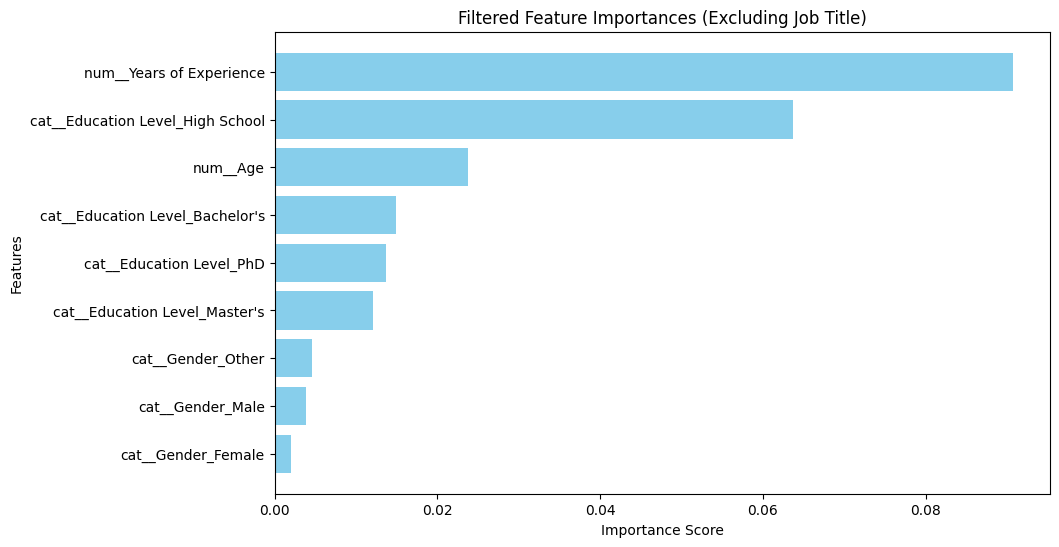

In [29]:
import matplotlib.pyplot as plt
#define feature importance
regressor = best_model.named_steps['regressor']

# Retrieve feature names after encoding
encoded_feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Get feature importances
feature_importances = regressor.feature_importances_

# Combine feature names with their importance scores
importance_df = pd.DataFrame({
    'Feature': encoded_feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

filtered_importance_df = importance_df[~importance_df['Feature'].str.contains('Job Title')]

print("\nFiltered Feature Importances (Excluding Job Title):")
print(filtered_importance_df)

# Visualize the filtered feature importances
plt.figure(figsize=(10, 6))
plt.barh(filtered_importance_df['Feature'], filtered_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Filtered Feature Importances (Excluding Job Title)')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
df = pd.read_csv(path)

print(df[df["Years of Experience"] == 1]["Salary"].mean())
print(df[(df["Years of Experience"] == 1) & (df["Job Title"] == "Software Engineer")]["Salary"].mean())
print(df[df["Years of Experience"] >= 7]["Salary"].mean())

46992.846296296295
51900.0
153342.697829233
